In [ ]:
# !pip install signatory==1.2.3.1.6.0 --no-cache-dir --force-reinstall

In [5]:
!pip install git+https://github.com/patrick-kidger/torchcde.git

  Cloning https://github.com/patrick-kidger/torchcde.git to /tmp/pip-req-build-2wrqox78
  Running command git clone -q https://github.com/patrick-kidger/torchcde.git /tmp/pip-req-build-2wrqox78
  Created wheel for torchcde: filename=torchcde-0.1.0-cp36-none-any.whl size=26752 sha256=7c7eef259992b6567b96d2cc066b71ffe448de34fef4823a2ad2898d723686ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-6udfz4cw/wheels/27/70/62/fcc2954fe81b4263df3751dbd62599080933abee0a3f4736b4
Successfully built torchcde


In [6]:
pip install git+https://github.com/google-research/torchsde.git

  Cloning https://github.com/google-research/torchsde.git to /tmp/pip-req-build-wsodp1vc
  Running command git clone -q https://github.com/google-research/torchsde.git /tmp/pip-req-build-wsodp1vc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 25.9MB 131kB/s 
     |████████████████████████████████| 174kB 52.3MB/s 
  Created wheel for torchsde: filename=torchsde-0.2.4-cp36-none-any.whl size=55585 sha256=68adbe1bfc648152c2d329cffacd9834db367af84da8274c654b60661c059dae
  Stored in directory: /tmp/pip-ephem-wheel-cache-5wg2dofq/wheels/31/b5/4b/53c7d7c124c1bbfebd2c5f429ca86b5e59f6cd4718dc0f1229
Successfully built torchsde
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [1]:
!git clone 'https://github.com/crispitagorico/Signature-Kernel.git'

Cloning into 'Signature-Kernel'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 755 (delta 125), reused 118 (delta 61), pack-reused 570
Receiving objects: 100% (755/755), 25.30 MiB | 34.87 MiB/s, done.
Resolving deltas: 100% (427/427), done.


In [2]:
%cd /content/Signature-Kernel/src/ 

!python setup.py build_ext --inplace

/content/Signature-Kernel/src
Compiling sigKer_fast.pyx because it changed.
[1/1] Cythonizing sigKer_fast.pyx
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Signature-Kernel/src/sigKer_fast.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'sigKer_fast' extension
creating build/temp.linux-x86_64-3.6
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -c sigKer_fast.c -o build/temp.linux-x86_64-3.6/sigKer_fast.o
creating build/lib.linux-x86_64-3.6
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIF

In [3]:
%cd /content/Signature-Kernel/notebooks/

/content/Signature-Kernel/notebooks


In [4]:
!git clone 'https://github.com/steveli/pytorch-sqrtm.git'

Cloning into 'pytorch-sqrtm'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 12 (delta 0), reused 1 (delta 0), pack-reused 9
Unpacking objects: 100% (12/12), done.


In [23]:
import sys
sys.path.append('../src')
sys.path.append('pytorch-sqrtm')

import numpy as np
import math
import torch
import matplotlib.pyplot as plt

from sqrtm import sqrtm

import torchsde
import torchcde

# import signatory

from sigMMD import SigMMD

In [24]:
y_dim = 2
brownian_dim = 2
# T = 20.

device = 'cuda'

In [25]:
class Lotka_Volterra_SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self, num_samples, a=.3, b=.0025, c=.15):
        super().__init__()

        self.num_samples = num_samples
        self.a = a
        self.b = b
        self.c = c

    def f(self, t, y):

        A = torch.zeros((self.num_samples, y_dim), dtype=y.dtype, device=y.device)
        
        A[:,0] = self.a*y[:,0] - self.b*y[:,0]*y[:,1] 
        A[:,1] = self.b*y[:,0]*y[:,1] - self.c*y[:,1]
        
        return A

    def g(self, t, y):

        B = torch.zeros((self.num_samples, y_dim, brownian_dim), dtype=y.dtype, device=y.device)

        B[:,0,0] = self.a*y[:,0] + self.b*y[:,0]*y[:,1]
        B[:,0,1] = -self.b*y[:,0]*y[:,1]
        B[:,1,0] = -self.b*y[:,0]*y[:,1]
        B[:,1,1] = self.b*y[:,0]*y[:,1] + self.c*y[:,1]

        for k in range(self.num_samples):
            B[k,:,:] = sqrtm(B[k,:,:])

        return B

In [26]:
def get_data(num_samples, length):
    
    # SDE simulator
    sde = Lotka_Volterra_SDE(num_samples)

    # initial condition
    y_0 = torch.tensor([50., 40.]).repeat(num_samples,1)

    # time grid
    times = torch.linspace(0., T, length)

    # Brownian motion simulator
    bm = torchsde.BrownianInterval(t0=0., t1=T, size=(num_samples, brownian_dim))

    # generate sample paths from solution
    y_paths = torchsde.sdeint(sde, y_0, times, bm=bm, dt=0.1) # shape (length, num_samples, solution_dim)
    y_paths = y_paths.permute(1,0,2)

    # generate sample increments from Brownian motion 
    bm_increments = torch.stack([bm(t0, t1) for t0, t1 in zip(times[:-1], times[1:])], dim=0)

    # generate sample paths from Brownian motion
    bm_paths = torch.cat((torch.zeros(1, num_samples, brownian_dim), torch.cumsum(bm_increments, dim=0)))
    bm_paths = bm_paths.permute(1,0,2)

    # include time as a channel
    times_ =  times.unsqueeze(0).unsqueeze(-1).expand(num_samples, length, 1)
    bm_paths = torch.cat([times_, bm_paths], dim=2)  

    return bm_paths, y_paths

In [16]:
# num_samples, length = 500, 50

In [17]:
# x_data, y_data = get_data(num_samples, length)

In [18]:
# x_data -= x_data.min()
# x_data /= x_data.max()

# y_data -= y_data.min()
# y_data /= y_data.max()

In [19]:
# torch.save(x_data, 'file_x_data.pt')
# torch.save(y_data, 'file_y_data.pt')

In [62]:
x_data = 5*torch.load('../data/file_x_data.pt')[::2,:-10:5,:]
y_data = 5*torch.load('../data/file_y_data.pt')[::2,:-10:5,:]

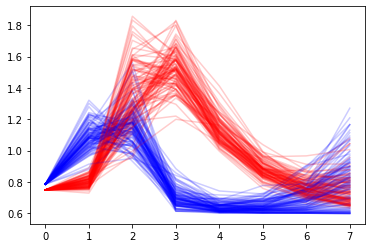

In [63]:
y_plot = y_data.cpu().numpy()
for k in range(100):
    plt.plot(y_plot[k][:,0], 'b', alpha=0.2)
    plt.plot(y_plot[k][:,1], 'r', alpha=0.2)
plt.show()

In [64]:
class VectorField(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, inner_dim=32):
        ######################
        # input_dim is the number of input channels in the data X. (Determined by the data.)
        # hidden_dim is the number of channels for z_t. (Determined by you.)
        ######################
        super(VectorField, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.linear1 = torch.nn.Linear(hidden_dim, inner_dim)
        self.linear2 = torch.nn.Linear(inner_dim, inner_dim)
        self.linear3 = torch.nn.Linear(inner_dim, input_dim * hidden_dim)

    ######################
    # The t argument is not used here; it can be used when you want your CDE to behave differently at different times.
    ######################
    def forward(self, t, z):

        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        # z = self.linear2(z)
        # z = z.relu()
        z = self.linear3(z)
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_dim, self.input_dim)
        return z

In [65]:
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        super(NeuralCDE, self).__init__()

        self.func = VectorField(input_dim, hidden_dim)

        self.initial = torch.nn.Linear(input_dim, hidden_dim)
        self.readout = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # x, t = torchcde.logsignature_windows(x, depth=2, window_length=5)

        coeffs = torchcde.linear_interpolation_coeffs(x)
        # coeffs = linear_interpolation_coeffs(X_input, rectilinear=0)
        X = torchcde.LinearInterpolation(coeffs)

        # coeffs = torchcde.natural_cubic_coeffs(x)
        # X = torchcde.NaturalCubicSpline(coeffs)
        
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)

        z = torchcde.cdeint(X=X, 
                            func=self.func, 
                            z0=z0, 
                            t=X.grid_points,
                            method='dopri5', 
                            options=dict(grid_points=X.grid_points, eps=1e-5)
                            )

        y = self.readout(z)
        return y

In [66]:
# input_dim=3 because we have a 2-d Brownian motion with time.
# hidden_dim=? is the number of hidden channels for the evolving z_t, which we get to choose.
# output_dim=2 because we have a 2-d response.

model = NeuralCDE(input_dim=3, hidden_dim=8, output_dim=2)
# model = NeuralCDE(input_dim=signatory.logsignature_channels(3,2), hidden_dim=8, output_dim=2)

In [68]:
x_train = x_data[100:250].cuda()#.double()
y_train = y_data[100:250].cuda()#.double()
x_test = x_data[:100].cuda()
y_test = y_data[:100].cuda()

model = model.cuda()#.double()

In [69]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [70]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

In [71]:
criterion = SigMMD(n=0, solver=1)
# criterion = torch.nn.MSELoss()

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):

    for batch in train_dataloader:
        x, y = batch
        pred_y = model(x)
        loss = criterion(pred_y, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if epoch%10==0:
        model.eval()
        with torch.no_grad():
            y_pred = model(x_test)
            test_loss = criterion(y_pred, y_test)
        print('Epoch: {}   Training loss: {}   Test loss: {}'.format(epoch, loss.item(), test_loss.item()))
        model.train()

Epoch: 0   Training loss: 0.7849806547164917   Test loss: 0.6424242854118347
Epoch: 10   Training loss: 0.4811953902244568   Test loss: 0.3557465076446533
Epoch: 20   Training loss: 0.23773038387298584   Test loss: 0.1419561505317688
Epoch: 30   Training loss: 0.0699547678232193   Test loss: 0.04649752750992775
Epoch: 40   Training loss: 0.028705831617116928   Test loss: 0.06046713516116142


In [61]:
y_pred = model(x_test)

In [ ]:
y_pred_ = y_pred.cpu().detach().numpy()
y_test_ = y_test.cpu().detach().numpy()

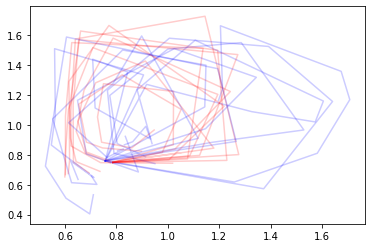

In [60]:
for k in range(100):
    plt.plot(y_pred_[k][:,0], y_pred_[k][:,1], 'b', alpha=0.2)
    plt.plot(y_test_[k][:,0], y_test_[k][:,1], 'r', alpha=0.2)
plt.show()

In [ ]:
plt.hist(y_pred_.sum(axis=1).sum(axis=1))
plt.hist(y_test_.sum(axis=1).sum(axis=1))
plt.show()

# Spirals Binary Classification

In [ ]:
# class NeuralCDE(torch.nn.Module):
#     def __init__(self, input_channels, hidden_channels, output_channels, log_sig=False, interpolation_type='cubic_splines'):
        
#         super(NeuralCDE, self).__init__()

#         self.func = F(input_channels, hidden_channels)
#         self.initial = torch.nn.Linear(input_channels, hidden_channels)
#         self.readout = torch.nn.Linear(hidden_channels, output_channels)
        
#         self.log_sig = log_sig
#         self.interpolation_type = interpolation_type
        
#     def forward_linear_interpolation(self, X_input):
#         coeffs = torchcde.linear_interpolation_coeffs(X_input)
# #         coeffs = linear_interpolation_coeffs(X_input, rectilinear=0)
#         X = torchcde.LinearInterpolation(coeffs)
    
#         X0 = X.evaluate(X.interval[0])
#         z0 = self.initial(X0)
        
#         z_T = torchcde.cdeint(X=X,
#                               z0=z0,
#                               func=self.func,
#                               t=X.interval,
#                               method='dopri5',
#                               options=dict(grid_points=X.grid_points, eps=1e-5))
        
#         return z_T
    
        
#     def forward_cubic_splines(self, X_input):
#         coeffs = torchcde.natural_cubic_coeffs(X_input)
#         X = torchcde.NaturalCubicSpline(coeffs)
        
#         X0 = X.evaluate(X.interval[0])
#         z0 = self.initial(X0)
        
#         z_T = torchcde.cdeint(X=X,
#                               z0=z0,
#                               func=self.func,
#                               t=X.interval)
        
#         return z_T
        
        
#     def forward_logsig(self, X_input, depth=2, window=5):
#         x, t = torchcde.logsignature_windows(X_input, depth, window)
#         return x
    
        
#     def forward(self, X_input):
        
#         if log_sig:
#             X_input = self.forward_logsig(X_input)
#             z_T = self.forward_linear_interpolation(X_input)
        
#         else:
#             if self.interpolation_type=='cubic_splines':
#                 z_T = self.forward_cubic_splines(X_input)
#             else:
#                 z_T = self.forward_linear_interpolation(X_input)
            
#         z_T = z_T[:, 1]
#         pred_y = self.readout(z_T)
#         return pred_y